In [28]:
pip install lifelines

     -------------------------------------- 409.4/409.4 kB 6.4 MB/s eta 0:00:00
     ---------------------------------------- 49.3/49.3 kB 2.6 MB/s eta 0:00:00
     ---------------------------------------- 88.9/88.9 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=9f821069578c8d5882f19bbc1f9f0172ee8f12732bcc8b222ba5cee73535b904
  Stored in directory: c:\users\alfan\appdata\local\pip\cache\wheels\e4\30\15\a77aac970f4acc37b9bb9c7f56e73c7c85087f15ff0fb4720f
Successfully built autograd-gamma
Note: you may need to restart the kernel to use updated packages.


In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import zipfile
import io
import os
import warnings

from lifelines import NelsonAalenFitter, CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [36]:
url = 'https://github.com/alfandysurya2/project_datasets/raw/main/CreditCardApprovalPrediction/CreditCardApprovalPrediction.zip'
app_record = '\\application_record.csv'
cred_record = '\\credit_record.csv'

current_directory = os.getcwd()

dataset_path = 'dataset'
output_path = 'output_data'
path = [dataset_path, output_path]
for i in path:
    os.makedirs(i, exist_ok=True)

df_full_path = os.path.join(current_directory, dataset_path)
output_full_path = os.path.join(current_directory, output_path)

In [37]:
response = requests.get(url)
if response.status_code == 200:
    zip_data = response.content
else:
    print(f"Failed to download ZIP dataset: {response.status_code} - {response.reason}")
    exit(1)
    
if not os.path.exists(df_full_path):
    os.makedirs(df_full_path, exist_ok=True)

with zipfile.ZipFile(io.BytesIO(zip_data)) as zip_file:
    zip_file.extractall(df_full_path)
    print(f"successfully extract all datasets to: {df_full_path}")

successfully extract all datasets to: C:\Users\alfan\Projects\portfolio\Credit Card Approval Prediction\dataset


In [38]:
application = pd.read_csv(df_full_path+app_record)
credit = pd.read_csv(df_full_path+cred_record)

In [51]:
application.info()
display(application.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [52]:
credit.info()
display(credit.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


#### Notes:

- **Months Balance** The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on.

- **Status** 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month.

### Vintage Analysis

"Vintage analysis" refers to a method used in various fields, such as finance, economics, and data analysis, to analyze the performance, characteristics, or behavior of a specific group of items or entities that share a common attribute or time period of origination. The term "vintage" in this context usually refers to the year or period in which something was created, produced, or originated.

The vintage analysis technique involves grouping items based on their vintage and then examining trends, patterns, or metrics within those groups. This approach can provide insights into how certain attributes or behaviors change over time or across different groups. Vintage analysis is particularly useful when dealing with data that has a temporal aspect, such as financial assets, loans, economic indicators, and more.

For example, in finance, vintage analysis might involve grouping loans based on the year they were originated and then analyzing the default rates, repayment behaviors, or other performance metrics for each vintage group. This can help lenders and analysts understand how the quality of loans has changed over different time periods.

In summary, vintage analysis is a method for studying the performance, characteristics, or behaviors of items or entities based on their common origination time period, enabling insights into how things have evolved over time.

In [43]:
print("Number of unique ID in application datasets: ", len(set(application['ID'])))

Number of unique ID in application datasets:  438510


In [44]:
print("Number of unique ID in credit datasets: ", len(set(credit['ID'])))

Number of unique ID in credit datasets:  45985


In [45]:
print("Number of ID intersection between application and credit datasets: ", 
      len(set(application['ID']).intersection(set(credit['ID']))))

Number of ID intersection between application and credit datasets:  36457


In [59]:
credit

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [57]:
grouped = credit.groupby('ID')
### convert credit data to wide format which every ID is a row
pivot_tb = credit.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min() # smallest value of MONTHS_BALANCE, is the month when loan was granted
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max()

pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'open_month', 'end_month']]
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month'] # calculate observe window
pivot_tb.reset_index(drop = True, inplace = True)

In [61]:
pivot_tb.head()

MONTHS_BALANCE,ID,open_month,end_month,window
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59


#### Code Explanation

In this cell, we basically create pivot table with `ID` as index, `MONTH_BALANCE` as columns, and `STATUS` as values of the pivot. On that table, we also created `open_month` and `end_month` columns with `open_month` is the minimum values of `MONTH_BALANCE` and `end_month` is the maximum values of `MONTH_BALANCE`. `open_month` is basically the month when loan was granted and `end_month` is when the current month of loan. Lastly, we created `window` is the delta of `end_month` and `open_month`.

In [60]:
credit = pd.merge(credit, pivot_tb, on = 'ID', how = 'left') # join calculated information
credit_copy = credit.copy()
credit = credit[credit['window'] > 20] # delete users whose observe window less than 20
credit['status'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) # analyze > 60 days past due 
credit['status'] = credit['status'].astype(np.int8) # 1: overdue 0: not
credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month'] # calculate month on book: how many months after opening account
credit.sort_values(by = ['ID','month_on_book'], inplace = True)

In [62]:
credit.head()

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,status,month_on_book
44,5001713,-21,X,-21,0,21,0,0
43,5001713,-20,X,-21,0,21,0,1
42,5001713,-19,X,-21,0,21,0,2
41,5001713,-18,X,-21,0,21,0,3
40,5001713,-17,X,-21,0,21,0,4


#### Code Explanation

In this cell, we merge the pivot table that we already created before with credit table on **ID** primary keys using left join. 

We filtered the data with observe `window` > 20 and then we basically binarize the credit `status` with the criteria:
1. If the `status` > 0 (2, 3, 4, 5) or more than 60 days past due we consider as 1 or **overdue**
2. Else the `status` = 0 or less than 60 days past due we consider as **not overdue**

lastly we create new column `month_on_book` that is the delta of `MONTHS_BALANCE` and `open_month` columns. This column basically tells how many months after opening account. After that we sort the table by `ID` and `month_on_book` ascendingly.

In [65]:
##### denominator
denominator = pivot_tb[['open_month', 'ID']].groupby(['open_month']).count() # count how many users in every month the account was opened
denominator.reset_index(inplace = True)
denominator.columns = ['open_month','sta_sum']

In [67]:
denominator.head()

,open_month,sta_sum
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470


#### Code Explanation

In this cell, we created denominator variable that is counting the number of users `ID` in every month the account was opened using groupby method. We renamed the counted number of users column as `sta_sum`.

In [85]:
##### ventage table
vintage = credit.groupby(['open_month','month_on_book']).agg({'ID': ['count']}) 
vintage.reset_index(inplace = True)
vintage.columns = ['open_month','month_on_book','sta_sum'] 
vintage['due_count'] = np.nan
vintage = vintage[['open_month','month_on_book','due_count']] # delete aggerate column
vintage = pd.merge(vintage, denominator, on = ['open_month'], how = 'left') # join sta_sum colun to vintage table

In [86]:
vintage.head()

,open_month,month_on_book,due_count,sta_sum
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415


#### Code Explanation

In this cell, we create vintage table. Here is the process of creating the vintage table:
1. Aggregate the credit table by `open_mont` and `month_on_book` with the count aggregate function on `ID` column.
2. Create `due_count` column with the value = `NaN`
3. Remove the aggregated column `sta_sum` and then join the vintage table with the denominator table on `open_month` column with left join method. 

In [89]:
for j in range(-60,1): # outer loop: month in which account was opened
    ls = []
    for i in range(0,61): # inner loop time after the credit card was granted
        due = list(credit[(credit['status'] == 1) & (credit['month_on_book'] == i) & (credit['open_month'] == j)]['ID']) # get ID which satisfy the condition
        ls.extend(due) # As time goes, add bad customers
        vintage.loc[(vintage['month_on_book'] == i) & (vintage['open_month'] == j), 'due_count'] = len(set(ls)) # calculate non-duplicate ID numbers using set()

vintage['sta_rate']  = vintage['due_count'] / vintage['sta_sum'] # calculate cumulative % of bad customers
vintage

,open_month,month_on_book,due_count,sta_sum,sta_rate
0,-60,0,0.0,415,0.000000
1,-60,1,0.0,415,0.000000
2,-60,2,0.0,415,0.000000
3,-60,3,0.0,415,0.000000
4,-60,4,0.0,415,0.000000
...,...,...,...,...,...
1655,-21,17,15.0,858,0.017483
1656,-21,18,15.0,858,0.017483
1657,-21,19,15.0,858,0.017483
1658,-21,20,15.0,858,0.017483


In [71]:
### Vintage wide table
vintage_wide = vintage.pivot(index = 'open_month',
                             columns = 'month_on_book',
                             values = 'sta_rate')
vintage_wide

month_on_book,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
open_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-60,0.00000,0.000000,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,0.009639,0.012048,0.014458,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.019277,0.019277,0.019277,0.019277,0.021687,0.021687,0.021687,0.021687,0.024096,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.00000,0.000000,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,0.012315,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.022167,0.024631,0.024631,0.027094,0.027094,0.027094,0.027094,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,0.011364,0.013636,0.013636,0.013636,0.013636,0.013636,0.013636,0.015909,0.018182,0.018182,0.018182,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.00000,0.000000,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,0.007500,0.007500,0.010000,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.00000,0.000000,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,0.021277,0.025532,0.029787,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55,0.00000,0.000000,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,0.024691,0.024691,0.024691,0.026749,0.032922,0.034979,0.037037,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.043210,0.043210,0.043210,0.043210,0.043210,0.043210,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54,0.00000,0.000000,0.000000,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,0.017094,0.019231,0.019231,0.023504,0.027778,0.027778,0.029915,0.029915,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,NaN,Na

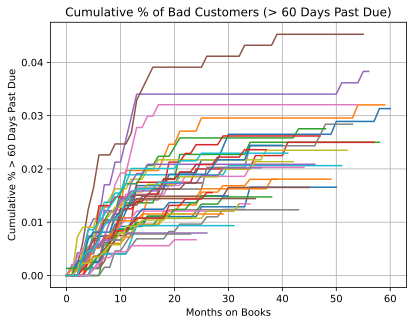

In [94]:
# plot vintage line chart
plt.rcParams['figure.facecolor'] = 'white'
vintage0 = vintage_wide.replace(0,np.nan)
lst = [i for i in range(0,61)]
vintage_wide[lst].T.plot(legend = False, grid = True, title = 'Cumulative % of Bad Customers (> 60 Days Past Due)')
#plt.axvline(30)
#plt.axvline(25)
#plt.axvline(20)
plt.xlabel('Months on Books')
plt.ylabel('Cumulative % > 60 Days Past Due')
plt.show()

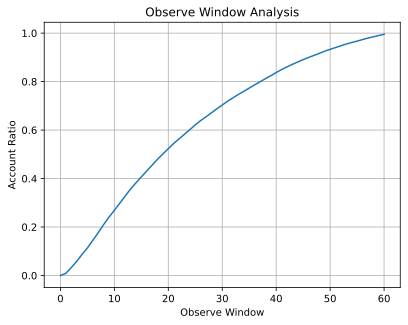

In [97]:
lst = []
for i in range(0,61):
    ratio = len(pivot_tb[pivot_tb['window'] < i]) / len(set(pivot_tb['ID']))
    lst.append(ratio)
    
pd.Series(lst).plot(legend = False, grid = True, title = 'Observe Window Analysis')
plt.xlabel('Observe Window')
plt.ylabel('Account Ratio')
plt.show()